# Prepare DepMap data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import janitor
from pathlib import Path
import re

In [2]:
data_dir = Path("../data")
save_dir = Path("../modeling_data")

## 'sample_info.csv'

In [3]:
sample_info_columns = [
    "depmap_id",
    "stripped_cell_line_name",
    "ccle_name",
    "sex",
    "cas9_activity",
    "primary_or_metastasis",
    "primary_disease",
    "subtype",
    "lineage",
    "lineage_subtype",
]

sample_info = pd.read_csv(data_dir / "sample_info.csv").clean_names()[
    sample_info_columns
]
sample_info.head()

,depmap_id,stripped_cell_line_name,ccle_name,sex,cas9_activity,primary_or_metastasis,primary_disease,subtype,lineage,lineage_subtype
0,ACH-000001,NIHOVCAR3,NIHOVCAR3_OVARY,Female,NaN,Metastasis,Ovarian Cancer,"Adenocarcinoma, high grade serous",ovary,ovary_adenocarcinoma
1,ACH-000002,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Female,NaN,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",blood,AML
2,ACH-000003,CACO2,CACO2_LARGE_INTESTINE,Male,NaN,NaN,Colon/Colorectal Cancer,Adenocarcinoma,colorectal,colorectal_adenocarcinoma
3,ACH-000004,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Male,47.6,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",blood,AML
4,ACH-000005,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Male,13.4,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",blood,AML


In [4]:
sample_info.to_csv(save_dir / "sample_info.csv", index=False)

## 'Achilles_guide_map.csv'

In [5]:
achilles_guide_map = (
    pd.read_csv(data_dir / "Achilles_guide_map.csv")
    .clean_names()
    .assign(hugo_symbol=lambda x: [a.split(" ")[0] for a in x.gene])
    .drop(["gene"], axis=1)
)

achilles_guide_map.head()

,sgrna,genome_alignment,n_alignments,hugo_symbol
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,1,SHOC2
1,AAAAAACCCGTAGATAGCCT,chr12_95003615_+,1,NDUFA12
2,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,1,SDAD1
3,AAAAAAGCTCAAGAAGGAGG,chr2_33588446_-,1,FAM98A
4,AAAAAAGGCTGTAAAAGCGT,chr19_19891600_+,1,ZNF253


## 'Achilles_dropped_guides.csv'

In [6]:
achilles_dropped_guides = (
    pd.read_csv(data_dir / "Achilles_dropped_guides.csv")
    .clean_names()
    .rename({"unnamed_0": "sgrna"}, axis=1)
)

achilles_dropped_guides.head()

,sgrna,genomic_coordinates,gene,n_alignments,fail_reason
0,AAAAAGCTTCCGCCTGATGG,NaN,NaN,0.0,not_aligned
1,AAAAATCCTAAAATAAAATA,chrX_145827835.0_-,NaN,1.0,in_dropped_guides
2,AAAACAGAATATAGTCAGTG,chrX_145827787.0_-,NaN,1.0,guide_dropped_by_ceres
3,AAAACAGGACGATGTGCGGC,NaN,NaN,0.0,not_aligned
4,AAAACATCGACCGAAAGCGT,NaN,NaN,0.0,not_aligned


In [7]:
len(np.unique(achilles_dropped_guides.sgrna))

2554

In [8]:
achilles_guide_map = achilles_guide_map[
    ~achilles_guide_map.sgrna.isin(achilles_dropped_guides.sgrna)
]
achilles_guide_map = achilles_guide_map.reset_index(drop=True)

In [9]:
achilles_guide_map.to_csv(save_dir / "achilles_guide_map.csv", index=False)

## 'Achilles_replicate_map.csv'

In [10]:
achilles_replicate_map = (
    pd.read_csv(data_dir / "Achilles_replicate_map.csv")
    .clean_names()
    .assign(replicate_id=lambda x: x.replicate_id.str.lower())
)
achilles_replicate_map.head()

,replicate_id,depmap_id,pdna_batch,passes_qc
0,pacadd188-311cas9_repb_p6_batch3,ACH-001382,3,True
1,kmrc20-311cas9_repa_p6_batch3,ACH-000250,3,True
2,253j-311cas9_repa_p5_batch3,ACH-000011,3,True
3,ocug1-311cas9-repb-p6_batch3,ACH-001619,3,True
4,raji-311cas9_repb_p6_batch3,ACH-000654,3,True


In [11]:
np.max(achilles_replicate_map.pdna_batch)

4

In [12]:
len(np.unique(achilles_replicate_map.replicate_id))

1638

In [13]:
np.round(np.mean(achilles_replicate_map.passes_qc), 3)

0.996

In [14]:
achilles_replicate_map.to_csv(save_dir / "achilles_replicate_map.csv", index=False)

## 'Achilles_logfold_change.csv'

In [15]:
achilles_logfold_change = (
    pd.read_csv(data_dir / "Achilles_logfold_change.csv")
    .rename({"Construct Barcode": "sgrna"}, axis=1)
    .set_index("sgrna")
    .melt(var_name="replicate_id", value_name="lfc", ignore_index=False)
    .reset_index()
    .assign(replicate_id=lambda x: x.replicate_id.str.lower())
    .merge(achilles_replicate_map, on="replicate_id", how="left")
    .pipe(lambda x: x[x.passes_qc])
)

achilles_logfold_change.head()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True


In [16]:
if achilles_logfold_change.depmap_id.isnull().values.any():
    raise Exception("Some data points are missing cell line assignments.")

In [17]:
if not np.all(achilles_logfold_change.passes_qc):
    raise Exception("Some data does not pass QC.")

In [18]:
achilles_logfold_change.shape

(121067627, 6)

In [19]:
achilles_logfold_change.to_csv(save_dir / "achilles_logfold_change.csv", index=False)

## 'CCLE_mutations.csv'

In [20]:
ccle_mutations_columns = [
    "depmap_id",
    "hugo_symbol",
    "chromosome",
    "start_position",
    "end_position",
    "variant_classification",
    "variant_type",
    "reference_allele",
    "tumor_seq_allele1",
    "cdna_change",
    "codon_change",
    "protein_change",
    "isdeleterious",
    "istcgahotspot",
    "iscosmichotspot",
]

ccle_mutations = pd.read_csv(
    data_dir / "CCLE_mutations.csv", delimiter="\t", low_memory=False
).clean_names()[ccle_mutations_columns]

ccle_mutations.head()

,depmap_id,hugo_symbol,chromosome,start_position,end_position,variant_classification,variant_type,reference_allele,tumor_seq_allele1,cdna_change,codon_change,protein_change,isdeleterious,istcgahotspot,iscosmichotspot
0,ACH-000986,A1BG,19,58858743,58858743,Missense_Mutation,SNP,C,T,c.1456G>A,c.(1456-1458)Gac>Aac,p.D486N,False,False,False
1,ACH-000988,A1BG,19,58858810,58858810,Silent,SNP,C,T,c.1389G>A,c.(1387-1389)caG>caA,p.Q463Q,False,False,False
2,ACH-002182,A1BG,19,58858867,58858867,Missense_Mutation,SNP,C,G,c.1332G>C,c.(1330-1332)aaG>aaC,p.K444N,False,False,False
3,ACH-000985,A1BG,19,58858872,58858872,Missense_Mutation,SNP,C,T,c.1327G>A,c.(1327-1329)Gtg>Atg,p.V443M,False,False,False
4,ACH-001793,A1BG,19,58858914,58858914,Missense_Mutation,SNP,C,T,c.1285G>A,c.(1285-1287)Gac>Aac,p.D429N,False,False,False


In [21]:
ccle_mutations.to_csv(save_dir / "ccle_mutations.csv", index=False)

### *KRAS* mutations

In [22]:
kras_mutations_columns = [
    "depmap_id",
    "start_position",
    "end_position",
    "variant_classification",
    "variant_type",
    "protein_change",
    "isdeleterious",
    "istcgahotspot",
    "iscosmichotspot",
]

kras_hotspot_codons = ["12", "13", "61", "146"]


kras_mutations = (
    ccle_mutations[ccle_mutations.hugo_symbol == "KRAS"][kras_mutations_columns]
    .assign(
        variant_classification=lambda x: x.variant_classification.str.lower(),
        variant_type=lambda x: x.variant_type.str.lower(),
        codon=lambda x: [re.sub("\D", "", a) for a in x.protein_change],
        is_kras_hotspot=lambda x: x.codon.isin(kras_hotspot_codons),
    )
    .pipe(lambda x: x[x.variant_classification != "silent"])
    .pipe(
        lambda x: x[
            x.is_kras_hotspot | x.iscosmichotspot | x.istcgahotspot | x.isdeleterious
        ]
    )
    .assign(
        kras_mutation=lambda x: [
            pc if vt == "missense_mutation" else vt
            for vt, pc in zip(x.variant_classification, x.protein_change)
        ]
    )
    .assign(kras_mutation=lambda x: [re.sub("p\\.", "", a) for a in x.kras_mutation])
    .drop_duplicates()
    .reset_index(drop=True)
)


kras_mutations.head()

,depmap_id,start_position,end_position,variant_classification,variant_type,protein_change,isdeleterious,istcgahotspot,iscosmichotspot,codon,is_kras_hotspot,kras_mutation
0,ACH-000981,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,frame_shift_del
1,ACH-001650,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,frame_shift_del
2,ACH-002238,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,frame_shift_del
3,ACH-000996,25368455,25368455,nonsense_mutation,snp,p.R164*,True,False,False,164,False,nonsense_mutation
4,ACH-000218,25378561,25378561,missense_mutation,snp,p.A146V,False,True,True,146,True,A146V


In [23]:
kras_mutation_counts = (
    kras_mutations[["kras_mutation", "depmap_id"]]
    .groupby("kras_mutation")
    .count()
    .sort_values("depmap_id", ascending=False)
)

# List of KRAS mutations to group as "other".
kras_others = (
    kras_mutation_counts.reset_index().pipe(lambda x: x[x.depmap_id < 2]).kras_mutation
)

kras_mutation_counts

,depmap_id
kras_mutation,
G12D,68
G12V,47
G12C,27
G12A,16
G13D,14
Q61H,9
G12R,8
G12S,8
A146T,7


In [24]:
# Assign rare KRAS mutations to "other" group.
kras_mutations = kras_mutations.assign(
    kras_mutation=lambda x: [
        "other" if kras_others.isin([a]).any() else a for a in x.kras_mutation
    ]
)

In [25]:
mult_kras_mutations = (
    kras_mutations[["depmap_id", "kras_mutation"]]
    .groupby("depmap_id")
    .count()
    .pipe(lambda x: x[x.kras_mutation > 1])
    .sort_values("kras_mutation", ascending=False)
    .reset_index(drop=False)
)

mult_kras_mutations

,depmap_id,kras_mutation
0,ACH-000718,3
1,ACH-000249,2
2,ACH-000264,2
3,ACH-000314,2
4,ACH-000344,2
5,ACH-001001,2
6,ACH-001094,2
7,ACH-001378,2
8,ACH-001650,2
9,ACH-001857,2


In [26]:
kras_mult_mutations_fix = (
    kras_mutations[kras_mutations.depmap_id.isin(mult_kras_mutations.depmap_id)]
    .reset_index(drop=True)
    .pipe(lambda x: x[x.is_kras_hotspot])
    .sort_values("depmap_id")
    .reset_index(drop=True)
)

kras_mult_mutations_fix

,depmap_id,start_position,end_position,variant_classification,variant_type,protein_change,isdeleterious,istcgahotspot,iscosmichotspot,codon,is_kras_hotspot,kras_mutation
0,ACH-000249,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,Q61H
1,ACH-000264,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
2,ACH-000264,25380277,25380278,missense_mutation,dnp,p.Q61K,False,True,True,61,True,Q61K
3,ACH-000314,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,Q61H
4,ACH-000314,25398282,25398282,missense_mutation,snp,p.G13C,False,True,True,13,True,G13C
5,ACH-000344,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
6,ACH-000344,25380277,25380278,missense_mutation,dnp,p.Q61K,False,True,True,61,True,Q61K
7,ACH-000718,25398284,25398284,missense_mutation,snp,p.G12V,False,True,True,12,True,G12V
8,ACH-000718,25398285,25398285,missense_mutation,snp,p.G12C,False,True,True,12,True,G12C
9,ACH-000718,25398284,25398285,missense_mutation,dnp,p.G12F,False,True,True,12,True,other


In [27]:
# Cell lines to ignore because they have multiple KRAS mutations that are
# not easily resolved.
true_kras_double_muts = ["ACH-000718", "ACH-000314", "ACH-001378", "ACH-001857"]

(
    kras_mult_mutations_fix[["depmap_id", "kras_mutation"]]
    .groupby("depmap_id")
    .count()
    .sort_values("kras_mutation", ascending=False)
    .reset_index(drop=False)
)

,depmap_id,kras_mutation
0,ACH-000718,3
1,ACH-000264,2
2,ACH-000314,2
3,ACH-000344,2
4,ACH-001378,2
5,ACH-001857,2
6,ACH-000249,1
7,ACH-001001,1
8,ACH-001094,1
9,ACH-001650,1


In [28]:
kras_mult_mutations_fix = (
    kras_mult_mutations_fix.assign(
        kras_mutation=lambda x: [
            "double_mut" if a in true_kras_double_muts else b
            for a, b in zip(x.depmap_id, x.kras_mutation)
        ]
    )
    .groupby("depmap_id")
    .first()
    .reset_index(drop=False)
)
kras_mult_mutations_fix

,depmap_id,start_position,end_position,variant_classification,variant_type,protein_change,isdeleterious,istcgahotspot,iscosmichotspot,codon,is_kras_hotspot,kras_mutation
0,ACH-000249,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,Q61H
1,ACH-000264,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
2,ACH-000314,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,double_mut
3,ACH-000344,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
4,ACH-000718,25398284,25398284,missense_mutation,snp,p.G12V,False,True,True,12,True,double_mut
5,ACH-001001,25398285,25398285,missense_mutation,snp,p.G12S,False,True,True,12,True,G12S
6,ACH-001094,25398285,25398285,missense_mutation,snp,p.G12S,False,True,True,12,True,G12S
7,ACH-001378,25398284,25398284,missense_mutation,snp,p.G12V,False,True,True,12,True,double_mut
8,ACH-001650,25398284,25398284,missense_mutation,snp,p.G12D,False,True,True,12,True,G12D
9,ACH-001857,25398285,25398285,missense_mutation,snp,p.G12C,False,True,True,12,True,double_mut


In [29]:
kras_mutations = kras_mutations.pipe(
    lambda x: x[~x.depmap_id.isin(kras_mult_mutations_fix.depmap_id)]
)

kras_mutations = pd.concat([kras_mutations, kras_mult_mutations_fix])

In [30]:
mult_kras_mutations = (
    kras_mutations[["depmap_id", "kras_mutation"]]
    .groupby("depmap_id")
    .count()
    .pipe(lambda x: x[x.kras_mutation > 1])
    .sort_values("kras_mutation", ascending=False)
    .reset_index(drop=False)
)

print(f"Number of cell lines with multiple KRAS mutations: {len(mult_kras_mutations)}")

Number of cell lines with multiple KRAS mutations: 0


In [31]:
kras_mutations.to_csv(save_dir / "kras_mutations.csv", index=False)

## 'CCLE_segment_cn.csv'

In [32]:
ccle_segment_cn = (
    pd.read_csv(data_dir / "CCLE_segment_cn.csv")
    .clean_names()
    .assign(copy_number=lambda x: [2 ** a for a in x.segment_mean])
)
ccle_segment_cn.head()

,depmap_id,chromosome,start,end,num_probes,segment_mean,source,copy_number
0,ACH-000001,1,1,1969745,286,2.546065,Sanger WES,5.840389
1,ACH-000001,1,1969746,6354345,365,2.175759,Sanger WES,4.518235
2,ACH-000001,1,6354346,6958256,100,3.109430,Sanger WES,8.630414
3,ACH-000001,1,6958257,15977206,884,2.134831,Sanger WES,4.391857
4,ACH-000001,1,15977207,16174774,57,2.952592,Sanger WES,7.741386


In [33]:
ccle_segment_cn.to_csv(save_dir / "ccle_semgent_cn.csv", index=False)

## 'CCLE_gene_cn.csv'

In [34]:
ccle_gene_cn = (
    pd.read_csv(data_dir / "CCLE_gene_cn.csv")
    .rename({"Unnamed: 0": "depmap_id"}, axis=1)
    .melt(id_vars="depmap_id", var_name="hugo_symbol", value_name="log2_cn_p1")
    .assign(
        hugo_symbol=lambda x: [a.split(" ")[0] for a in x.hugo_symbol],
        copy_number=lambda x: np.exp(x.log2_cn_p1) - 1,
    )
)

ccle_gene_cn.head()

,depmap_id,hugo_symbol,log2_cn_p1,copy_number
0,ACH-000001,A1BG,1.179621,2.253141
1,ACH-000002,A1BG,1.009801,1.745055
2,ACH-000003,A1BG,1.022828,1.781048
3,ACH-000004,A1BG,1.232225,2.428849
4,ACH-000005,A1BG,1.151880,2.164136


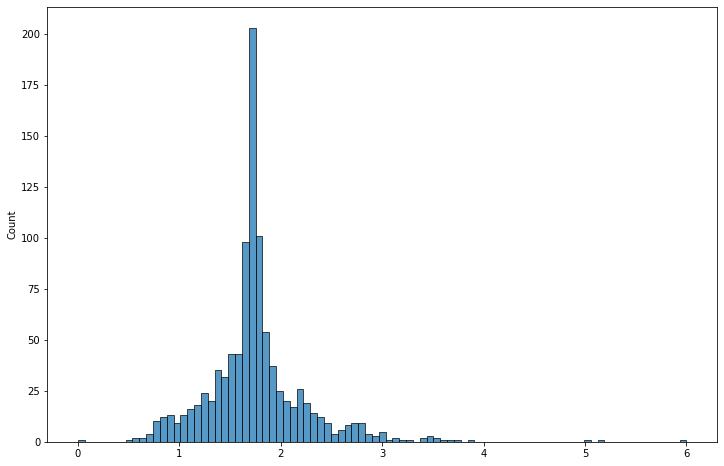

In [43]:
fig = plt.figure(figsize=(12, 8))
x = [np.min([a, 6]) for a in ccle_gene_cn.copy_number.sample(n=1000)]
sns.histplot(x, kde=False)
plt.show()

## 'CCLE_fusions.csv'

In [36]:
ccle_fusions = (
    pd.read_csv(data_dir / "CCLE_fusions.csv", delimiter="\t")
    .clean_names()
    .rename(
        {
            "#fusionname": "fusion_name",
            "junctionreadcount": "junction_read_count",
            "spanningfragcount": "spanning_frag_count",
            "splicetype": "splice_type",
            "leftgene": "left_gene",
            "leftbreakpoint": "left_break_point",
            "rightgene": "right_gene",
            "rightbreakpoint": "right_break_point",
            "largeanchorsupport": "large_anchor_support",
            "leftbreakdinuc": "left_break_dinuc",
            "leftbreakentropy": "left_break_entropy",
            "rightbreakdinuc": "right_break_dinuc",
            "rightbreakentropy": "right_break_entropy",
        },
        axis=1,
    )
)
ccle_fusions.head()

,depmap_id,fusion_name,junction_read_count,spanning_frag_count,splice_type,left_gene,left_break_point,right_gene,right_break_point,large_anchor_support,ffpm,left_break_dinuc,left_break_entropy,right_break_dinuc,right_break_entropy,annots,ccle_count
0,ACH-001113,CACNA2D1--SEMA3E,48,53,ONLY_REF_SPLICE,CACNA2D1 (ENSG00000153956),chr7:82335135:-,SEMA3E (ENSG00000170381),chr7:83469302:-,YES_LDAS,1.5703,GT,1.9899,AG,1.9899,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr7:0.92M...",2
1,ACH-001113,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2 (ENSG00000101544),chr18:80117650:+,PLIN3 (ENSG00000105355),chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2
2,ACH-001113,XRCC4--SUGCT,23,104,ONLY_REF_SPLICE,XRCC4 (ENSG00000152422),chr5:83111203:+,SUGCT (ENSG00000175600),chr7:40749434:+,YES_LDAS,1.9745,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr5--chr7]""]",2
3,ACH-001113,PCYT1A--RBFOX1,26,48,ONLY_REF_SPLICE,PCYT1A (ENSG00000161217),chr3:196247367:-,RBFOX1 (ENSG00000078328),chr16:6654603:+,YES_LDAS,1.1505,GT,1.7819,AG,1.8295,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr3--chr1...",4
4,ACH-001113,AF117829.1--PIP4P2,25,31,ONLY_REF_SPLICE,AF117829.1 (ENSG00000251136),chr8:89757045:-,PIP4P2 (ENSG00000155099),chr8:90996744:-,YES_LDAS,0.8707,GT,1.8062,AG,1.9329,"[""INTRACHROMOSOMAL[chr8:1.24Mb]""]",2


In [37]:
ccle_fusions.to_csv(save_dir / "ccle_fusions.csv", index=False)

## 'CCLE_expression_full_v2.csv'

In [5]:
ccle_expression = (
    pd.read_csv(data_dir / "CCLE_expression_full_v2.csv")
    .rename({"Unnamed: 0": "depmap_id"}, axis=1)
    .melt(id_vars="depmap_id", var_name="hugo_symbol", value_name="rna_expr")
    .assign(hugo_symbol=lambda x: [a.split(" ")[0] for a in x.hugo_symbol])
)

ccle_expression.head()

,depmap_id,hugo_symbol,rna_expr
0,ACH-001097,TSPAN6,0.000000
1,ACH-001636,TSPAN6,0.000000
2,ACH-001804,TSPAN6,4.934988
3,ACH-000534,TSPAN6,0.839960
4,ACH-001498,TSPAN6,1.744161


In [6]:
ccle_expression.to_csv(save_dir / "ccle_expression.csv", index=False)